In [78]:
import os

import tiledb
import affine
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

In [79]:
%matplotlib inline

# Load data

In [76]:
tiledb_path = '../data/tiledb-array-1'

In [7]:
!tree {tiledb_path}

../data/tiledb-array-1
├── __1634217003060_1634217003060_810117fed1384ac2bcc6cca586cf90cd_9
│   ├── a0.tdb
│   └── __fragment_metadata.tdb
├── __1634217003060_1634217003060_810117fed1384ac2bcc6cca586cf90cd_9.ok
├── __array_schema.tdb
├── __lock.tdb
└── __meta
    └── __1634217001936_1634217001936_20ab0b0d9daf455ea0b93d7cc06062cb

2 directories, 6 files


In [77]:
# Read the array schema
# note this does not actually load any data
schema = tiledb.ArraySchema.load(tiledb_path)
schema

ArraySchema(
  domain=Domain(*[
    Dim(name='BANDS', domain=(1, 1), tile='1', dtype='uint64'),
    Dim(name='Y', domain=(0, 11007), tile='256', dtype='uint64'),
    Dim(name='X', domain=(0, 11007), tile='256', dtype='uint64'),
  ]),
  attrs=[
    Attr(name='TDB_VALUES', dtype='uint16', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)

In [95]:
# define a bounding box to slice out of the image
# This is be Beale Airforce Base in EPSG 32610 (UTM zone 10N)
minx, miny, maxx, maxy = 628154, 4329783, 644982, 4337321

In [96]:
# Open the array in read mode and slice only a portion of the array
# try to use the UTM coordinates directly
with tiledb.open(tiledb_path, 'r') as A:
    print(A[:, miny:maxy, minx:maxx]["BANDS"])

TileDBError: [TileDB::Dimension] Error: Cannot add range to dimension; Lower range bound 4329783 cannot be larger than the higher bound 11007

In [97]:
# Seems that writing with GDAL has not done anything clever with the image CRS
# No CRS has been stored, X/Y dimension is just pixel coordinates
# There is no time dimension either, but presumably this would have to be handled manually
# Let's at least retry to read that same bbox by finding the pixel coordinates of the bbox

In [98]:
def coordinates_to_pixel_xy(coordinates, dataset, utm=True):
    """Return pixel coordinates of a point"""
    data_source = gdal.OpenShared(dataset)
    x, y = coordinates[0], coordinates[1]
    forward_transform = affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)
    
    # UTM is reversed lon,lat (i.e. y,x)
    if utm:
        return py, px
    
    return px, py

In [99]:
pminx, pminy = coordinates_to_pixel_xy((minx, miny), '../data/1.tif')
pmaxx, pmaxy = coordinates_to_pixel_xy((maxx, maxy), '../data/1.tif')

In [104]:
# Open the array in read mode and slice only a portion of the array
with tiledb.open(tiledb_path, 'r') as A:
    result = A[:, pmaxx:pminx, pminy:pmaxy]

In [105]:
# result is an OrderedDict of numpy arrays
# here we only have a single band containing the values
result.keys()

odict_keys(['TDB_VALUES'])

In [106]:
result['TDB_VALUES'].squeeze().shape

(754, 1683)

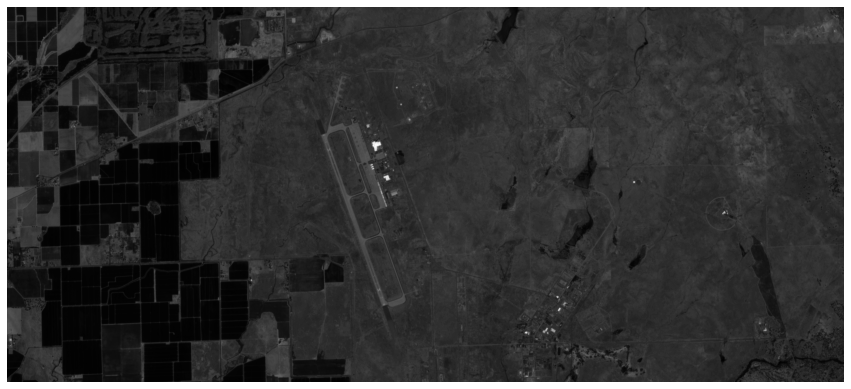

In [116]:
# plot it
f, ax = plt.subplots(1, figsize=(15, 15))
ax.imshow(result['TDB_VALUES'].squeeze(), cmap='gist_gray')
ax.set_axis_off()